In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datasets
from collections import defaultdict
from score import ci, parse_filename, score, sample_dir, sample_file, subject_tags, cache_dir, model_slice

computing scores...


In [2]:
print('computing scores...')
results = {}
for i, model in enumerate(sorted(os.listdir(sample_dir))):
    path = os.path.join(sample_dir, model, sample_file)
    info = parse_filename(model)
    desc = f"({i + 1} / {len(os.listdir(sample_dir))})"
    scores = score(path, desc=desc, cache_dir=cache_dir)
    results[info] = scores
print("done")

dataset = datasets.load_dataset("RLAIF/math")
all_subjects = np.array(dataset["test"]["subject"])

computing scores...
done


Found cached dataset parquet (/Users/ryan/.cache/huggingface/datasets/RLAIF___parquet/RLAIF--math-03f03fc418f6ba96/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

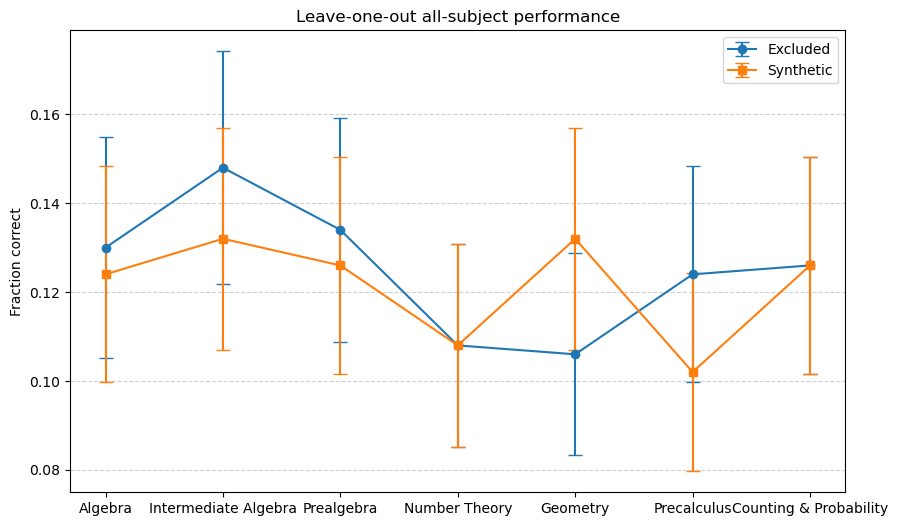

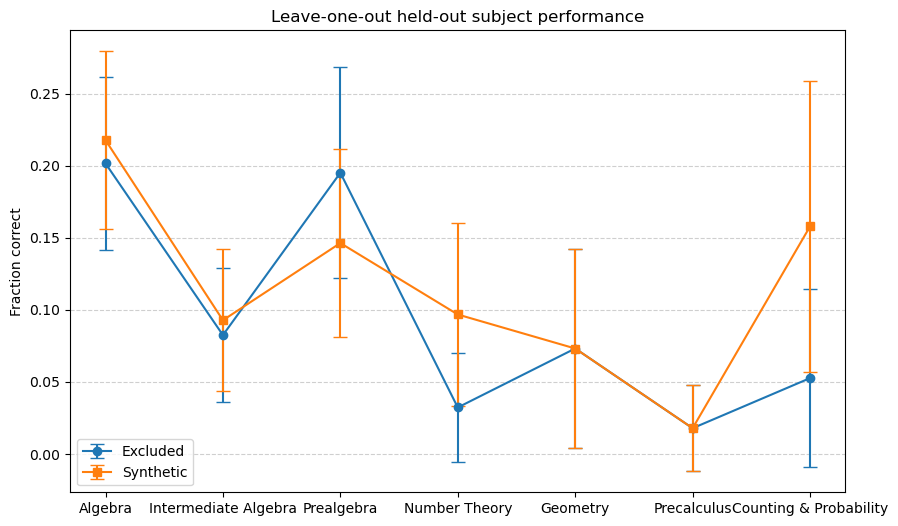

In [6]:
# if we take one subject out at a time, how do we do?
def get_subject_scores(scores, subject):
    if isinstance(subject, list) or isinstance(subject, np.ndarray):
        return scores[np.isin(all_subjects, subject)]
    return scores[all_subjects == subject].astype(int)

def dd():
    return defaultdict(dd)

oneout_scores = dd()

for subject in subject_tags:
    scores_excluded = results[model_slice(excluded=[subject])]
    scores_synthetic = results[model_slice(synthetic=[subject])]
    oneout_scores["total"]["excluded"]["means"][subject] = scores_excluded.mean()
    oneout_scores["total"]["excluded"]["cis"][subject] = ci(scores_excluded)
    oneout_scores["total"]["synthetic"]["means"][subject] = scores_synthetic.mean()
    oneout_scores["total"]["synthetic"]["cis"][subject] = ci(scores_synthetic)

    subject_scores_excluded = get_subject_scores(scores_excluded, subject)
    subject_scores_synthetic = get_subject_scores(scores_synthetic, subject)
    oneout_scores["subject"]["excluded"]["means"][subject] = subject_scores_excluded.mean()
    oneout_scores["subject"]["excluded"]["cis"][subject] = ci(subject_scores_excluded)
    oneout_scores["subject"]["synthetic"]["means"][subject] = subject_scores_synthetic.mean()
    oneout_scores["subject"]["synthetic"]["cis"][subject] = ci(subject_scores_synthetic)

for type_ in ("total", "subject"):
    excluded_means = [oneout_scores[type_]["excluded"]["means"][subject] for subject in subject_tags]
    excluded_cis = [oneout_scores[type_]["excluded"]["cis"][subject] for subject in subject_tags]
    synthetic_means = [oneout_scores[type_]["synthetic"]["means"][subject] for subject in subject_tags]
    synthetic_cis = [oneout_scores[type_]["synthetic"]["cis"][subject] for subject in subject_tags]
    
    plt.figure(figsize=(10, 6))
    
    plt.errorbar(subject_tags.keys(), excluded_means, yerr=excluded_cis, label="Excluded", fmt='-o', capsize=5)
    plt.errorbar(subject_tags.keys(), synthetic_means, yerr=synthetic_cis, label="Synthetic", fmt='-s', capsize=5)
    
    plt.ylabel("Fraction correct")
    plt.title("Leave-one-out all-subject performance" if type_ == "total" else "Leave-one-out held-out subject performance")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    name = "leave_one_out__" + ("all_subjects" if type_ == "total" else "held_out") + ".png"
    plt.savefig(f"figs/{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

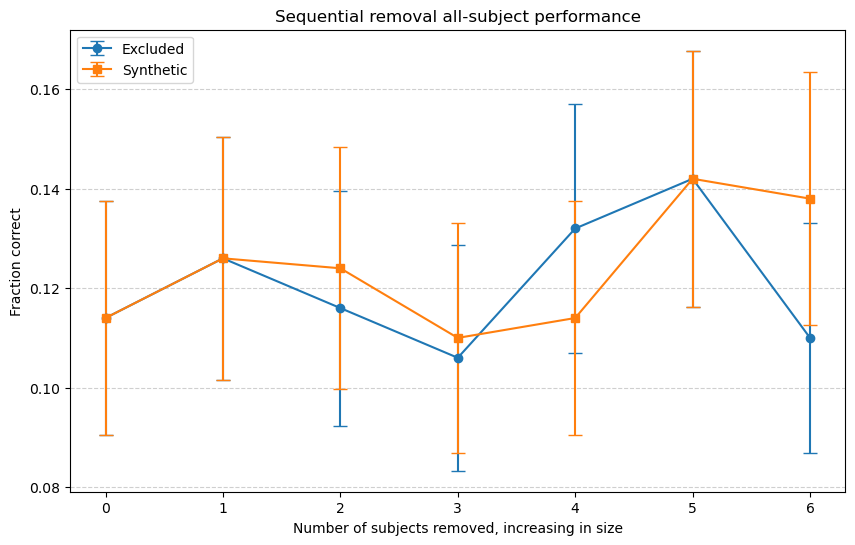

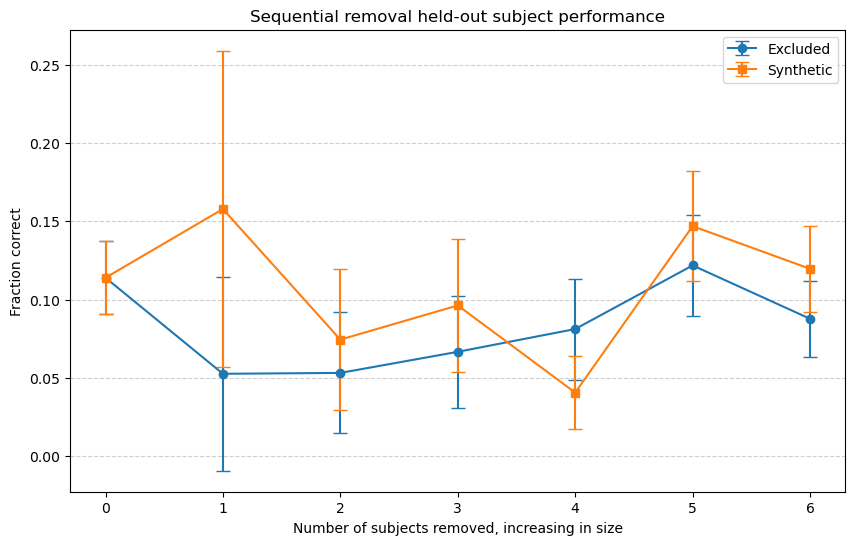

In [7]:
# if we take out subjects sequentially, how does performance compare?
sequential_scores = dd()
subjects = list(reversed(subject_tags.keys()))

for i in range(len(subjects)):
    scores_excluded = results[model_slice(excluded=subjects[:i])]
    scores_synthetic = results[model_slice(synthetic=subjects[:i])]
    sequential_scores["total"]["excluded"]["means"][i] = scores_excluded.mean()
    sequential_scores["total"]["excluded"]["cis"][i] = ci(scores_excluded)
    sequential_scores["total"]["synthetic"]["means"][i] = scores_synthetic.mean()
    sequential_scores["total"]["synthetic"]["cis"][i] = ci(scores_synthetic)

    # subject score = scores for all excluded subjects
    subject_scores_excluded = get_subject_scores(scores_excluded, subjects[:i])
    subject_scores_synthetic = get_subject_scores(scores_synthetic, subjects[:i])
    if i != 0:
        sequential_scores["subject"]["excluded"]["means"][i] = subject_scores_excluded.mean()
        sequential_scores["subject"]["excluded"]["cis"][i] = ci(subject_scores_excluded)
        sequential_scores["subject"]["synthetic"]["means"][i] = subject_scores_synthetic.mean()
        sequential_scores["subject"]["synthetic"]["cis"][i] = ci(subject_scores_synthetic)
    else:
        for k1 in ("excluded", "synthetic"):
            for k2 in ("means", "cis"):
                sequential_scores["subject"][k1][k2][i] = sequential_scores["total"][k1][k2][i]

for type_ in ("total", "subject"):
    excluded_means = [sequential_scores[type_]["excluded"]["means"][i] for i in range(len(subjects))]
    excluded_cis = [sequential_scores[type_]["excluded"]["cis"][i] for i in range(len(subjects))]
    synthetic_means = [sequential_scores[type_]["synthetic"]["means"][i] for i in range(len(subjects))]
    synthetic_cis = [sequential_scores[type_]["synthetic"]["cis"][i] for i in range(len(subjects))]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(list(range(len(subjects))), excluded_means, yerr=excluded_cis, label="Excluded", fmt='-o', capsize=5)
    plt.errorbar(list(range(len(subjects))), synthetic_means, yerr=synthetic_cis, label="Synthetic", fmt='-s', capsize=5)

    plt.xlabel("Number of subjects removed, increasing in size")
    plt.ylabel("Fraction correct")
    plt.title("Sequential removal all-subject performance" if type_ == "total" else "Sequential removal held-out subject performance")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    name = "sequential__" + ("all_subjects" if type_ == "total" else "held_out") + ".png"
    plt.savefig(f"figs/{name}.png", dpi=300, bbox_inches="tight")
    plt.show()